In [1]:
import os
import gc
import sys
import random
from pathlib import Path
from pprint import pprint, pformat
from functools import partial

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

py_version = sys.version.replace('\n', ' ')
print(f"Python version: {py_version}\n")
print(f"Sklearn version: {sklearn.__version__}")

INPUT = Path('/kaggle/input/ieee-random-forest')
pprint(list(INPUT.glob('*')))

Python version: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16)  [GCC 7.3.0]

Sklearn version: 0.22.1
[PosixPath('/kaggle/input/ieee-random-forest/random_forest.sav'),
 PosixPath('/kaggle/input/ieee-random-forest/clean_train.pkl'),
 PosixPath('/kaggle/input/ieee-random-forest/custom.css'),
 PosixPath('/kaggle/input/ieee-random-forest/__notebook__.ipynb'),
 PosixPath('/kaggle/input/ieee-random-forest/__results__.html'),
 PosixPath('/kaggle/input/ieee-random-forest/__output__.json'),
 PosixPath('/kaggle/input/ieee-random-forest/pkl.csv'),
 PosixPath('/kaggle/input/ieee-random-forest/clean_test.pkl')]


In [2]:
list(Path('/kaggle/input/').glob('*'))

[PosixPath('/kaggle/input/ieee-random-forest')]

In [3]:
import joblib
model = joblib.load(INPUT / 'random_forest.sav')
model

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.22.1. This might lead to breaking cod

RandomForestRegressor(bootstrap=True, ccp_alpha=None, criterion='mse',
                      max_depth=None, max_features=0.3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [4]:
train_x = pd.read_pickle(INPUT / 'clean_train.pkl')
print(train_x.shape)
train_x.head()

(590540, 815)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V43_isna,V312_isna,V146_isna,id_04_isna,V66_isna,V207_isna,V17_isna,V154_isna,V19_isna,V39_isna
0,2987000,0,86400,68.5,4,10095,500,42,1,38,...,True,False,True,True,False,True,False,True,False,True
1,2987001,0,86401,29.0,4,1372,303,42,2,2,...,False,False,True,True,False,True,False,True,False,False
2,2987002,0,86469,59.0,4,2833,389,42,3,58,...,False,False,True,False,False,True,False,True,False,False
3,2987003,0,86499,50.0,4,13341,466,42,2,14,...,False,False,True,True,False,True,False,True,False,False
4,2987004,0,86506,50.0,1,2712,413,42,2,2,...,True,False,False,False,True,False,True,False,True,True


In [5]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [6]:
cols = train_x.columns.drop('TransactionID')
cols = cols.drop('isFraud')
cols = cols.drop('TransactionDT')
cols

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'V43_isna', 'V312_isna', 'V146_isna', 'id_04_isna', 'V66_isna',
       'V207_isna', 'V17_isna', 'V154_isna', 'V19_isna', 'V39_isna'],
      dtype='object', length=812)

In [7]:
len(model.feature_importances_)

812

In [8]:
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index = cols,
    columns=['importance']
).sort_values('importance', ascending=False)
print("Top 20 Features:")
display(feature_importances.head(20))

Top 20 Features:


,importance
V258,0.085317
C1,0.047789
V257,0.044285
V201,0.043964
C13,0.036907
C14,0.030158
C12,0.025924
V244,0.022135
card2,0.021041
TransactionAmt,0.020901


Now let's try to visualize it

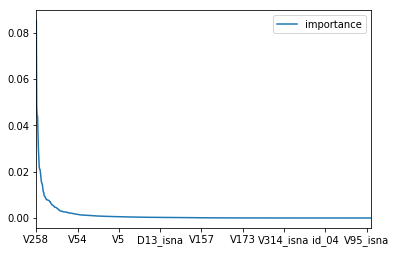

In [9]:
feature_importances.plot()

Thats not super readable but we can see that most of value is coming from a small number of features. Theres something over 800 features in the dataset so we can probably try excluding some of the less important ones and see if that degrades our model performance.

In [10]:
pct = 0.9
df = feature_importances
df = df[df.importance.gt(df.importance.quantile(pct))]